# Mood Navigator

In [1]:
# EDA
import joblib
import torch
import pandas as pd
import numpy as np

# Load Data Viz Pkgs
import seaborn as sns

# Load Text Cleaning Pkgs
import neattext.functions as nfx

# Load ML Pkgs
# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Lstm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

#Bert
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [2]:
# Load Dataset
df = pd.read_csv("../data/mood_dataset.csv")
dt = pd.read_csv("../data/Daylio_Abid.csv")

In [3]:
df.head(11)

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...
5,fear,I'm expecting an extremely important phonecall...
6,sadness,.Couldnt wait to see them live. If missing th...
7,surprise,maken Tip 2: Stop op een moment dat je het hel...
8,surprise,En dan krijg je ff een cadeautje van een tweep...
9,surprise,@1116am Drummer Boy bij op verzoek van @BiemO...


In [4]:
dt.head(11)

,full_date,date,weekday,time,sub_mood,activities,mood
0,16/04/2021,Apr-16,Friday,8:00 pm,yolo,reading | Art | prayer | fasting | walk | med...,Good
1,15/04/2021,Apr-15,Thursday,2:37 am,focused,reading | learning | Art | prayer | fasting ...,Good
2,14/04/2021,Apr-14,Wednesday,2:39 am,confused,reading | learning | prayer | fasting | Qura...,Normal
3,13/04/2021,Apr-13,Tuesday,2:38 am,wondering,reading | learning | Art | prayer | fasting ...,Normal
4,12/04/2021,Apr-12,Monday,9:52 pm,angry,reading | learning | fasting | walk | medita...,Awful
5,11/04/2021,Apr-11,Sunday,12:21 am,wondering,reading | learning | prayer | fasting | walk...,Normal
6,10/04/2021,Apr-10,Saturday,12:20 am,blessed,reading | learning | prayer | walk | meditati...,Good
7,09/04/2021,Apr-09,Friday,12:20 am,yolo,reading | learning | prayer | fasting | walk...,Good
8,08/04/2021,Apr-08,Thursday,11:07 pm,excited,reading | learning | Art | meditation | show...,Amazing
9,07/04/2021,Apr-07,Wednesday,9:02 pm,yolo,reading | learning | fasting | walk | medita...,Good


In [5]:
# Value Counts
df['Emotion'].value_counts()

Emotion
joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: count, dtype: int64

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Emotion', ylabel='count'>

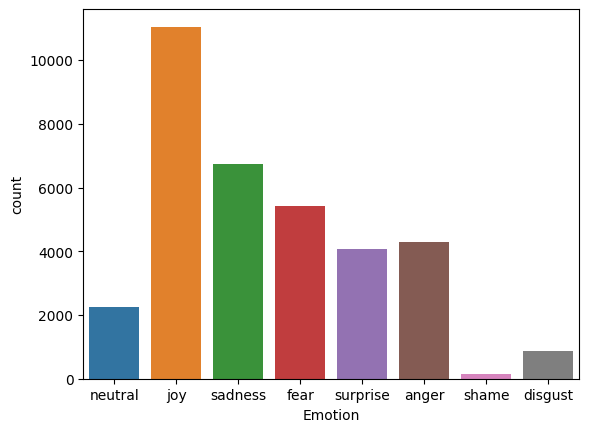

In [6]:
# Plot
sns.countplot(x='Emotion',data=df)

In [32]:
# Data Cleaning
dir(nfx)


['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

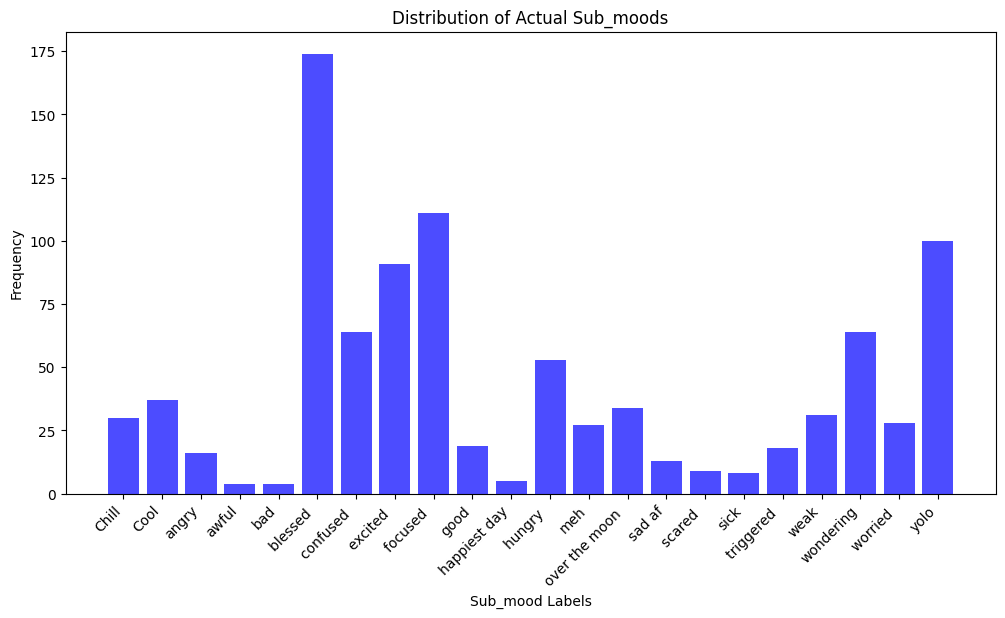

In [7]:
import matplotlib.pyplot as plt

# Assuming model is already trained and sub_mood_labels is defined
actual_sub_moods = dt['sub_mood'].astype(str)
unique_sub_moods = sorted(set(actual_sub_moods))

# Count occurrences of each sub_mood
counts = [actual_sub_moods.tolist().count(sub_mood) for sub_mood in unique_sub_moods]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(unique_sub_moods, counts, color='blue', alpha=0.7)
plt.xlabel('Sub_mood Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Sub_moods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

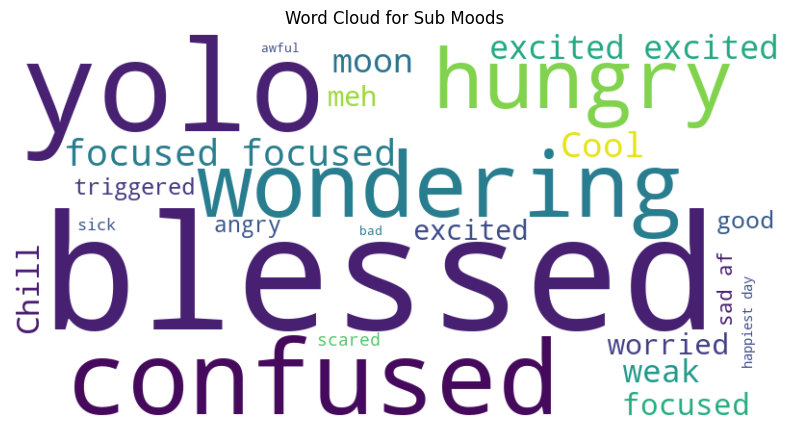

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all sub_moods into a single string
all_sub_moods_text = ' '.join(dt['sub_mood'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(all_sub_moods_text)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Sub Moods')
plt.show()

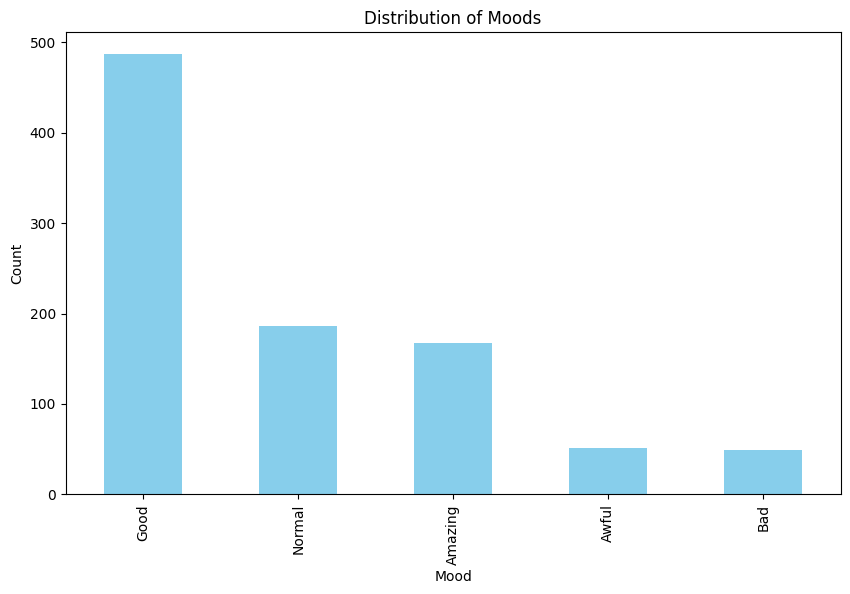

In [8]:
import matplotlib.pyplot as plt

# Assuming df["mood"] is the column containing the mood labels
mood_counts = dt["mood"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
mood_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Moods')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.show()

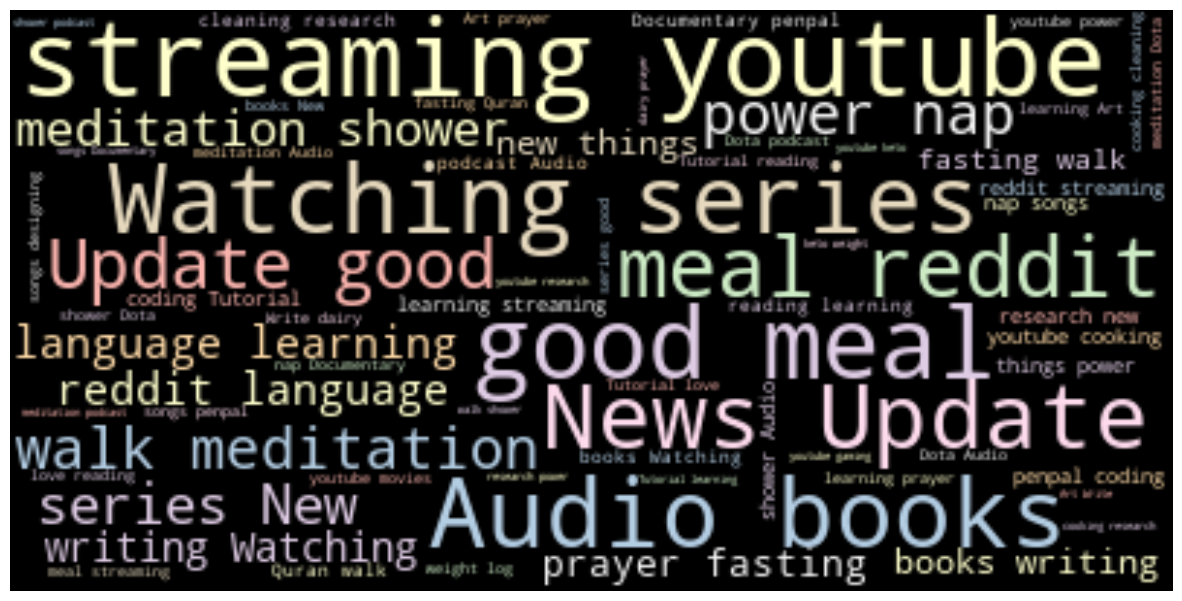

<Figure size 1000x600 with 0 Axes>

In [46]:
#word cloud
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in dt.activities)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=200,colormap='Pastel1', background_color="black").generate(text)
plt.figure(figsize=(10,6))
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

In [47]:
# Cell 3
# Sort the DataFrame based on the 'full_date' column
dt['full_date'] = pd.to_datetime(dt['full_date'], format='%d/%m/%Y')
dt = dt.sort_values(by='full_date')

# Display the sorted DataFrame
print("Sorted DataFrame:")
print(dt)

Sorted DataFrame:
     full_date    date    weekday      time   sub_mood  \
939 2018-02-03  Feb-03   Saturday   3:12 pm        meh   
938 2018-02-03  Feb-03   Saturday   7:52 pm      angry   
936 2018-02-04  Feb-04     Sunday  11:23 am        meh   
937 2018-02-04  Feb-04     Sunday   6:34 am   blessed    
935 2018-02-04  Feb-04     Sunday   8:19 pm       yolo   
..         ...     ...        ...       ...        ...   
4   2021-04-12  Apr-12     Monday   9:52 pm      angry   
3   2021-04-13  Apr-13    Tuesday   2:38 am  wondering   
2   2021-04-14  Apr-14  Wednesday   2:39 am  confused    
1   2021-04-15  Apr-15   Thursday   2:37 am   focused    
0   2021-04-16  Apr-16     Friday   8:00 pm       yolo   

                                            activities    mood  \
939  walk | meditation  | Dota 2 | Audio books  | s...  Normal   
938      Write dairy  | Dota 2 | streaming  | shopping   Awful   
936                  meditation  | youtube | research   Normal   
937              pray

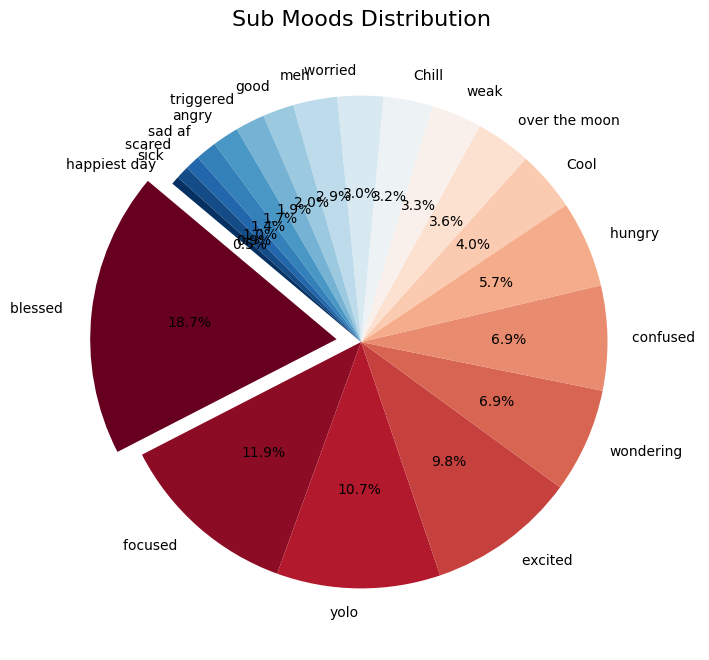

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
colors = plt.cm.RdBu(np.linspace(0, 1, 20))
sub_mood_counts = dt["sub_mood"].value_counts().sort_values(ascending=False).head(20)

# Customizations
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # Explode the first slice
labels = sub_mood_counts.index  # Use sub_mood names as labels

# Plot the pie chart
plt.figure(figsize=(10, 8))
plt.pie(sub_mood_counts, labels=labels, autopct="%0.1f%%", colors=colors, explode=explode, startangle=140)

# Title and formatting
plt.title("Sub Moods Distribution", fontsize=16)
plt.axis("off")  # Turn off the axis

# Show the pie chart
plt.show()

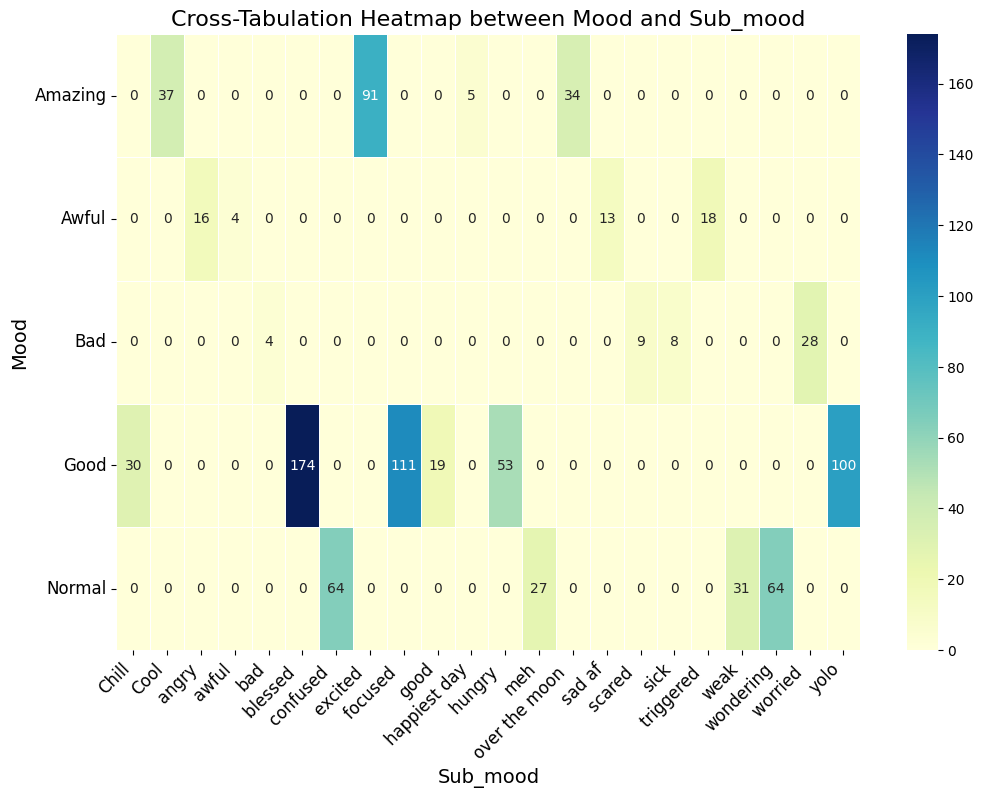

In [49]:
import seaborn as sns

# Assuming df has two categorical columns 'mood' and 'sub_mood'
cross_tab = pd.crosstab(dt['mood'], dt['sub_mood'])
plt.figure(figsize=(12, 8))

# Customize the heatmap
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', cbar=True, linewidths=.5)
plt.title('Cross-Tabulation Heatmap between Mood and Sub_mood', fontsize=16)
plt.xlabel('Sub_mood', fontsize=14)
plt.ylabel('Mood', fontsize=14)

# Rotate the axis labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Show the modified heatmap
plt.show()

<Figure size 1400x800 with 0 Axes>

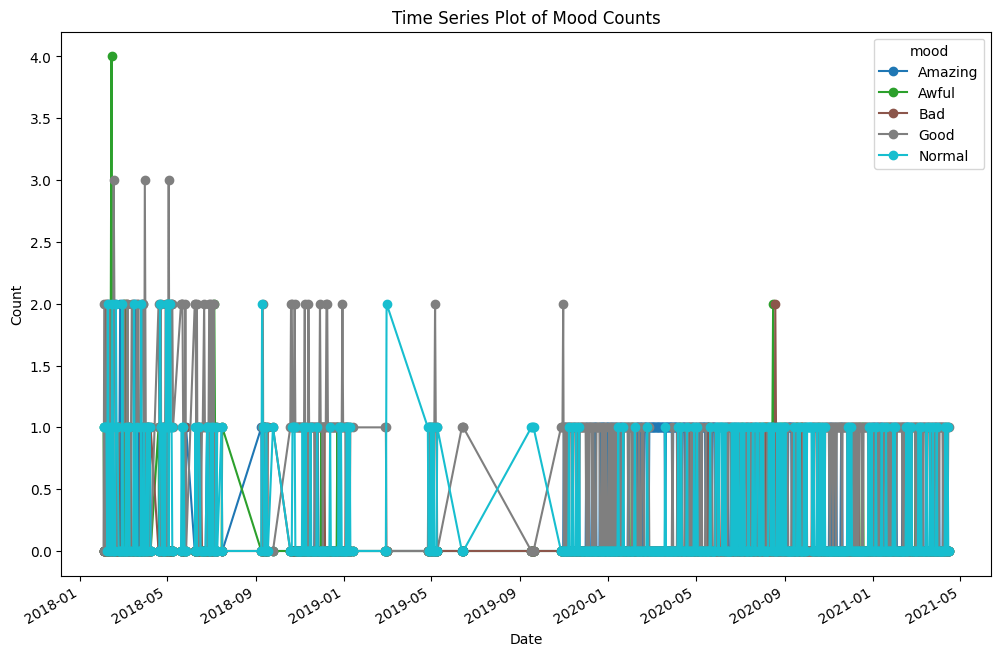

In [50]:
# Assuming df has a datetime column 'full_date'
df_time_series = dt.groupby('full_date')['mood'].value_counts().unstack().fillna(0)
plt.figure(figsize=(14, 8))
df_time_series.plot(kind='line', marker='o', colormap='tab10', figsize=(12, 8))
plt.title('Time Series Plot of Mood Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

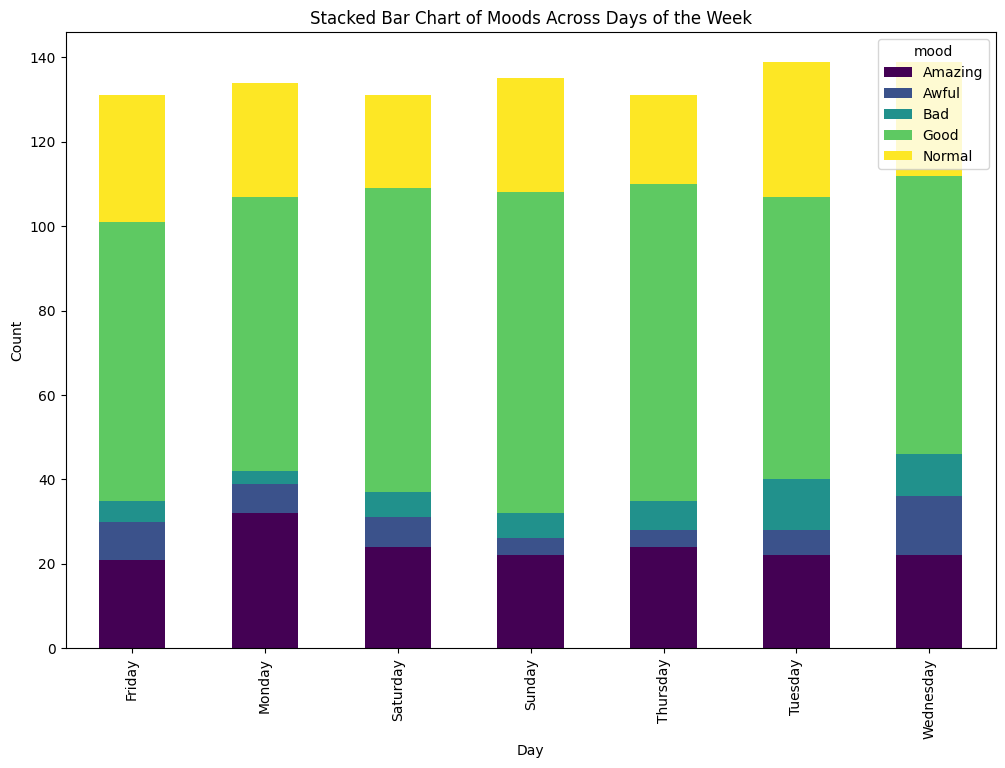

In [51]:
# Assuming you have a column 'weekday' and 'mood'
stacked_data = dt.groupby(['weekday', 'mood']).size().unstack(fill_value=0)
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Stacked Bar Chart of Moods Across Days of the Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

# BERT

In [34]:
# Data Preprocessing
# Combining sub_mood, activities, weekday, and time into a single text column
dt['combined'] = dt['sub_mood'].astype(str) + " " + dt['activities'].astype(str) + " " + dt['weekday'].astype(str) + " " + dt['time'].astype(str)

# Label Encoding for mood
label_encoder = LabelEncoder()
dt['mood_encoded'] = label_encoder.fit_transform(dt['mood'])

# BERT Tokenization and Encoding
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
max_len = 128
tokenized_texts = tokenizer(
    dt['combined'].tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=max_len,
)
input_ids = tokenized_texts['input_ids']
attention_mask = tokenized_texts['attention_mask']

# Convert labels to PyTorch tensors
labels = torch.tensor(dt['mood_encoded'].values)

# Split into training, validation, and test sets
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    train_inputs, train_masks, train_labels, test_size=0.1, random_state=42
)

# Create TensorDatasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
# User handles
df['Clean_Text'] = df['Text'].apply(nfx.remove_userhandles)
# Stopwords
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)

In [37]:
# Features & Labels
Xfeatures = df['Clean_Text']
ylabels = df['Emotion']

In [38]:
#  Split Data
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=42)

In [39]:
# Build Pipeline
from sklearn.pipeline import Pipeline

In [40]:
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])
pipe_lr.fit(x_train,y_train)
pipe_lr.score(x_test,y_test)
ex1 = "This book was so interesting it made me happy"
pipe_lr.predict([ex1])
pipe_lr.predict_proba([ex1])
pipe_lr.classes_

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'shame',
       'surprise'], dtype=object)

In [42]:
# Save Model
pipeline_file = open("../models/mood_navigator.pkl","wb")
joblib.dump(pipe_lr,pipeline_file)
pipeline_file.close()